# Historical TC observations

Here, we explore the reliability of the historical record, in terms of the proportion of missing data in certain fields. 

In the IBTrACS database, missing values for central pressure and maximum wind speed are indicated by either '0' or '-1' values. We can quickly read through the database and count up the number of records with these values. 

In [1]:
%matplotlib inline

from __future__ import print_function, division

import io
import os
import sys
import numpy as np
import numpy.ma as ma
from os.path import join as pjoin

import matplotlib.pyplot as plt
import pandas as pd

from Utilities.config import ConfigParser
from Utilities.loadData import loadTrackFile
from Utilities.track import Track
from Utilities.metutils import convert

import seaborn as sns
sns.set_context("poster")
sns.set_style("whitegrid")

In [2]:
configstr = """
[DataProcess]
InputFile=/home/tcrm/tcrm/input/Allstorms.ibtracs_wmo.v03r09.csv
Source=IBTRACS
StartSeason=1981
FilterSeasons=True

[Region]
; Domain for windfield and hazard calculation
gridLimit={'xMin':90.,'xMax':180.,'yMin':-30.0,'yMax':-5.0}
gridSpace={'x':1.0,'y':1.0}
gridInc={'x':1.0,'y':0.5}

[TrackGenerator]
NumSimulations=5000
YearsPerSimulation=10
SeasonSeed=68876543
TrackSeed=334825
TimeStep=1.0

[Input]
landmask = /home/tcrm/tcrm/input/landmask.nc
mslpfile = /home/tcrm/tcrm//MSLP/slp.day.ltm.nc
datasets = IBTRACS,LTMSLP

[Output]
Path=/media/sf_share/tcrm/fiji/

[Hazard]
Years=2,5,10,20,25,50,100,200,250,500,1000,2000,2500,5000
MinimumRecords=10
CalculateCI=False

[Logging]
LogFile=/media/sf_share/tcrm/fiji/log/fiji.log
LogLevel=INFO
Verbose=False

[IBTRACS]
; Input data file settings
url = ftp://eclipse.ncdc.noaa.gov/pub/ibtracs/v03r06/wmo/csv/Allstorms.ibtracs_wmo.v03r09.csv.gz
path = /home/tcrm/tcrm/input/
filename = Allstorms.ibtracs_wmo.v03r09.csv
columns = tcserialno,season,num,skip,skip,skip,date,skip,lat,lon,skip,pressure
fielddelimiter = ,
numberofheadinglines = 3
pressureunits = hPa
lengthunits = km
dateformat = %Y-%m-%d %H:%M:%S
speedunits = kph

[LTMSLP]
; MSLP climatology file settings
URL = ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.derived/surface/slp.day.1981-2010.ltm.nc
path = /home/tcrm/tcrm/MSLP
filename = slp.day.ltm.nc"""

In [3]:
config = ConfigParser()
config.readfp(io.BytesIO(configstr))

In [4]:
trackFile = config.get('DataProcess', 'InputFile')
source = config.get('DataProcess', 'Source')


names=['serialNum', 'season', 'TCnum', 'Basin', 'subbasin',
       'Name', 'Datetime', 'TCNature', 'Latitude', 'Longitude',
       'Windspeed', 'Pressure', 'Centre','WindPercentile',
       'PressurePercentile', 'TrackType']

df = pd.read_csv(trackFile, names=names, skiprows=3, skipinitialspace=True)

Here, we filter the data so we're only looking at storms in the South Pacific basin. Using `pandas`, this is really quick. 

In [5]:
spdf = df[df['Basin'] == 'SP']

We then group the data by season, so we can count the number of missing or zero values. We then count the number of each value in each season using the `value_counts()` method. 

In [6]:
byseason = spdf.groupby('season')
byseason['Pressure'].value_counts()

season  Pressure
1907     993.0       3
         994.0       1
         996.0       1
         998.0       1
         1000.0      1
         1002.0      1
         1004.0      1
1908     999.0       3
         1000.0      2
         992.0       1
         1002.0      1
         1006.0      1
1909     996.0       2
         990.0       1
         992.0       1
         999.0       1
         1000.0      1
1910    -1.0         9
         988.0       1
1911    -1.0        39
         996.0       2
         988.0       1
         1000.0      1
1912    -1.0         9
         988.0       1
         998.0       1
1913    -1.0        34
         990.0       2
         1000.0      2
         985.0       1
                    ..
2015     938.0       1
         944.0       1
         945.0       1
         952.0       1
         953.0       1
         956.0       1
         959.0       1
         962.0       1
         968.0       1
         973.0       1
         974.0       1
         975.0   

In [ ]:
frequency = byseason['serialNum'].nunique()

Now we calculate the number of zero/missing values in the pressure field. Note because the presure field uses both '0' and '-1' to represent missing values, we need to do the value count twice (for each of these values). 

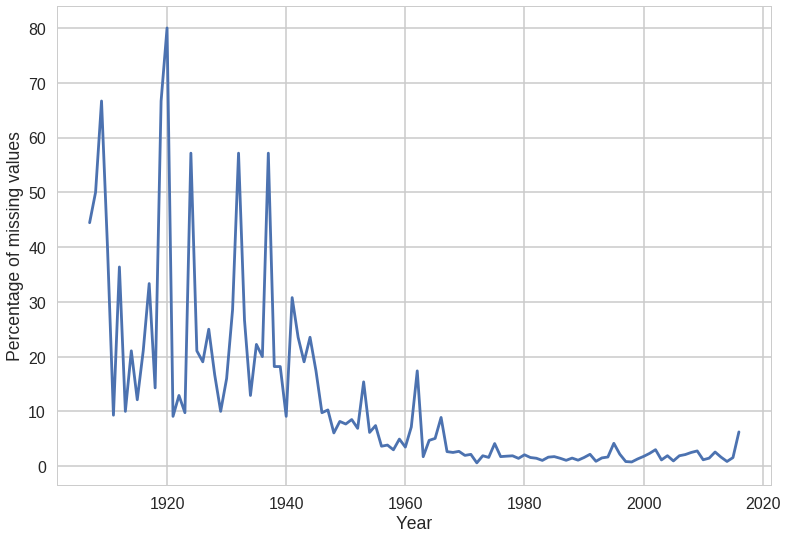

In [7]:
nzero = byseason['Pressure'].value_counts()[0]
nmiss = byseason['Pressure'].value_counts()[-1]
fraction = 100 * (nzero + nmiss) / byseason['Pressure'].count()

fig, ax = plt.subplots()
ax.plot(fraction, color='r', label='')
ax.set_ylim((0, 100))
ax2 = ax.twinx()
ax2.plot(frequency, color='b')
plt.xlabel('Year')
ax.set_ylabel("Percentage of missing values")
ax2.set_ylabel("Number of TCs")

It's only since the 1960's that the observations have become reasonably consistent in the percentage of missing data. 

### Determining the changepoint
However, we can be a little more rigorous about this. Using some simple Bayesian statistics, we can work out the most likely change point in the proprtion of missing data. This next little bit demonstrates using the `pymc` module to perform Monte Carlo Markov Chain modelling for the changepoint.

In [8]:
import pymc
arr = fraction.values
y0, y1 = fraction.index[0], fraction.index[-1]
switchpoint = pymc.DiscreteUniform('switchpoint', lower=0, upper=len(arr))
early_mean = pymc.Exponential('early_mean', beta=1)
late_mean = pymc.Exponential('late_mean', beta=1)

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

ImportError: numpy.core.multiarray failed to import

Here, we assume that the prior distribution of the changepoint is uniformly distributed between the first and last years. The distribution of the mean value of the proportion of missing data is presumed to be an exponential distribution (i.e. it's positive, but larger values are less likely). 

In [ ]:
@pymc.deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    out = np.empty(len(arr))
    out[:s] = e
    out[s:] = l
    return out

In [ ]:
storms = pymc.Poisson('quality', mu=rate, value=arr, observed=True)

model = pymc.Model([switchpoint, early_mean, late_mean, rate, storms])

mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000, burn=1000, thin=10)

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(311);
plt.plot(mcmc.trace('switchpoint')[:]+y0);
plt.ylabel("Switch point"); 
plt.subplot(312);
plt.plot(mcmc.trace('early_mean')[:]);
plt.ylabel("Early mean");
plt.subplot(313);
plt.plot(mcmc.trace('late_mean')[:]);
plt.xlabel("Iteration");
plt.ylabel("Late mean");
plt.tight_layout()

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(131);
plt.hist(mcmc.trace('switchpoint')[:] + y0, 15);
plt.xlabel("Switch point")
plt.ylabel("Distribution")
plt.subplot(132);
plt.hist(mcmc.trace('early_mean')[:], 15);
plt.xlabel("Early mean");
plt.subplot(133);
plt.hist(mcmc.trace('late_mean')[:], 15);
plt.xlabel("Late mean");
plt.tight_layout()

In [ ]:
yp = y0 + mcmc.trace('switchpoint')[:].mean()
em = mcmc.trace('early_mean')[:].mean()
lm = mcmc.trace('late_mean')[:].mean()
print((yp, em, lm))

In [ ]:
plt.figure(figsize=(14,6));
plt.plot(fraction.index, arr, '-ok');
plt.axvline(yp, color='k', ls='--');
plt.plot([y0, yp], [em, em], '-b', lw=3);
plt.plot([yp, y1], [lm, lm], '-r', lw=3);
plt.xlim(y0, y1);
plt.xlabel("Year");
plt.ylabel("Percentage of missing data");

Based on this analysis, the change point is around 1945/1946, where the (annual) mean proportion of missing data falls to about 2.9%. It's possible to tweak this to give a slightly more informative prior for the distribution of the changepoint, but I'll leave that to others.